In [1]:
# Imports
import gc
import numpy as np
import cv2
import pandas as pd
import random
from keras.models import Sequential
from keras.models import model_from_json
import os
import matplotlib.pyplot as plt
import skimage.feature
import keras
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils.training_utils import multi_gpu_model
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, Cropping2D
from keras.utils import np_utils
%matplotlib inline

c:\users\vincenzo\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# We define in advance constants to build the model

INPUT_SHAPE = (96, 96, 3)
OUTPUT_SIZE = 2

LEARNING_RATE = 0.0001
OPTIMIZER = keras.optimizers.Adam()
LOSS = 'binary_crossentropy'
METRIC = 'accuracy'

EPOCHS = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 50

MODEL_PATH = "./binary_classifier/net_0_model.json"
WEIGHTS_PATH = "./binary_classifier/net_0_weights.h5"

In [3]:
# Use a random seed
random.seed(42)

In [4]:
# Load patches for sea lions
def extract_patches(path, size, label):
    data_set = []
    for file in range(0, size):
        patch = cv2.imread("./patches/" + path + "/" + str(file) + ".jpg")
        data_set.append(list((patch, label)))
    return data_set

In [5]:
# Extract train patches
data_set_sea_lions_train = extract_patches("sealions_train", 62652, "sea lion")
data_set_background_train = extract_patches("background_train", 62652, "background")

In [6]:
# Build train set
train_set = data_set_sea_lions_train + data_set_background_train
random.shuffle(train_set)
X_train = []
Y_train = []
for data in train_set:
    X_train.append(data[0])
    if data[1] == "sea lion":
        Y_train.append([1, 0])
    elif data[1] == "background":
        Y_train.append([0, 1])
X_train = np.array(X_train, copy=False)
Y_train = np.array(Y_train, copy=False)

# Free memory
data_set_sea_lions_train = []
data_set_background_train = []
train_set = []
gc.collect()

# Convert data types and normalize values
X_train = X_train.astype('float32')
X_train /= 255

In [7]:
# Build parallel model (multi gpu)

model = Sequential()
# First layer
model.add(Convolution2D(8, (5, 5), activation='relu', padding='valid', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# Second layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# Third layer
model.add(Convolution2D(5, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# Fourth layer
model.add(Convolution2D(10, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())

# model.add(Dropout(0.5))
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=[METRIC])

In [8]:
# Train (multi gpu)

# Fit model on training data
history = parallel_model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, verbose=1)


Train on 100243 samples, validate on 25061 samples
Epoch 1/100
100243/100243 [==============================] - 83s 826us/step - loss: 0.3481 - acc: 0.8404 - val_loss: 0.2336 - val_acc: 0.9109
Epoch 2/100
100243/100243 [==============================] - 60s 598us/step - loss: 0.2143 - acc: 0.9180 - val_loss: 0.1972 - val_acc: 0.9241
Epoch 3/100
100243/100243 [==============================] - 58s 581us/step - loss: 0.1912 - acc: 0.9285 - val_loss: 0.1708 - val_acc: 0.9351
Epoch 4/100
100243/100243 [==============================] - 57s 567us/step - loss: 0.1787 - acc: 0.9337 - val_loss: 0.1743 - val_acc: 0.9377
Epoch 5/100
100243/100243 [==============================] - 59s 584us/step - loss: 0.1738 - acc: 0.9363 - val_loss: 0.1629 - val_acc: 0.9401
Epoch 6/100
100243/100243 [==============================] - 58s 579us/step - loss: 0.1683 - acc: 0.9387 - val_loss: 0.1875 - val_acc: 0.9303
Epoch 7/100
100243/100243 [==============================] - 57s 573us/step - loss: 0.1670 - acc:

Epoch 58/100
100243/100243 [==============================] - 52s 523us/step - loss: 0.0884 - acc: 0.9688 - val_loss: 0.0931 - val_acc: 0.9664
Epoch 59/100
100243/100243 [==============================] - 53s 525us/step - loss: 0.0888 - acc: 0.9692 - val_loss: 0.0943 - val_acc: 0.9652
Epoch 60/100
100243/100243 [==============================] - 53s 531us/step - loss: 0.0877 - acc: 0.9696 - val_loss: 0.0880 - val_acc: 0.9692
Epoch 61/100
100243/100243 [==============================] - 53s 525us/step - loss: 0.0868 - acc: 0.9695 - val_loss: 0.0863 - val_acc: 0.9699
Epoch 62/100
100243/100243 [==============================] - 52s 523us/step - loss: 0.0882 - acc: 0.9690 - val_loss: 0.1014 - val_acc: 0.9639
Epoch 63/100
100243/100243 [==============================] - 52s 523us/step - loss: 0.0857 - acc: 0.9695 - val_loss: 0.0968 - val_acc: 0.9668
Epoch 64/100
100243/100243 [==============================] - 52s 523us/step - loss: 0.0863 - acc: 0.9701 - val_loss: 0.1033 - val_acc: 0.9632

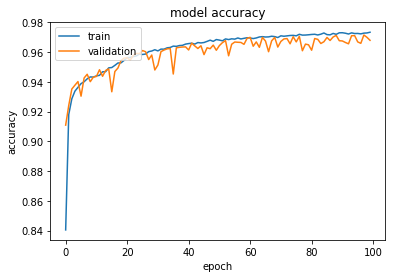

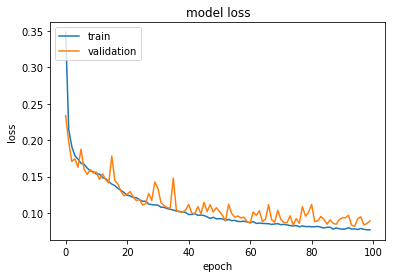

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
# Save trained model (multi gpu)

# serialize model to JSON
# model_json = parallel_model.to_json()
# with open(MODEL_PATH, "w") as json_file:
#     json_file.write(model_json)
# serialize weights to HDF5
parallel_model.save_weights(WEIGHTS_PATH)

# Free memory
X_train = []
Y_train = []
gc.collect()

11824

In [11]:
# Extract test patches

data_set_sea_lions_test = extract_patches("sealions_test", 17634, "sea lion")
data_set_background_test = extract_patches("background_test", 17634, "background")

In [12]:
# Build test set
test_set = data_set_sea_lions_test + data_set_background_test
random.shuffle(test_set)
X_test = []
Y_test = []
for data in test_set:
    X_test.append(data[0])
    if data[1] == "sea lion":
        Y_test.append([1, 0])
    elif data[1] == "background":
        Y_test.append([0, 1])
X_test = np.array(X_test, copy=False)
Y_test = np.array(Y_test, copy=False)

# Free memory
data_set_sea_lions_test = []
data_set_background_test = []
test_set = []
gc.collect()

# Convert data types and normalize values
X_test = X_test.astype('float32')
X_test /= 255

In [13]:
# Test (multi gpu)

# Evaluate model on test data
loss_and_metrics = parallel_model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, verbose=1)

print("%s: %.2f%%" % (parallel_model.metrics_names[1], loss_and_metrics[1]*100))

35268/35268 [==============================] - 9s 267us/step
acc: 96.60%


In [14]:
# Evaluate ROC and AUC

Y_pred = parallel_model.predict(X_test)
roc_auc_score(Y_test, Y_pred)

0.9928382826133575

In [15]:
# Free memory
X_test = []
Y_test = []
gc.collect()

0